In [1]:
import tqdm
import random
import xgboost
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

plt.style.use("jupyter")

In [3]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

feat = pd.read_csv("../data/zeo-features.csv", index_col=0)

## Training a multi-class classifier

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve

## Training for other synthesis conditions

In [12]:
classifiers = [
    LogisticRegression(),
    SVC(probability=True),
    RandomForestClassifier(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
    ),
]

results = []
_LABELS = synth.columns
THRESHOLD = 0.25
TEST_SIZE = 0.3
SEED = 42

for _label in tqdm.tqdm(_LABELS):
    X = dm
    y = (synth[_label] > THRESHOLD)
    
    n_pos = y.sum()
    n_neg = (~y).sum()

    if n_pos <= 10:
        continue
    
    X_pos, y_pos = X.loc[y], y.loc[y]
    X_neg, y_neg = X.loc[~y], y.loc[~y]
    i = np.arange(n_neg)
    i_neg = np.random.choice(i, n_pos)
    X_neg, y_neg = X_neg.iloc[i_neg], y_neg.iloc[i_neg]

    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=TEST_SIZE, random_state=SEED)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=TEST_SIZE, random_state=SEED)
    
    X_train = np.concatenate([X_train_pos, X_train_neg])
    X_test = np.concatenate([X_test_pos, X_test_neg])
    y_train = np.concatenate([y_train_pos, y_train_neg]).astype(int)
    y_test = np.concatenate([y_test_pos, y_test_neg]).astype(int)

    for clf in classifiers:

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        y_score = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        pr, rc, _ = pr_curve = precision_recall_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        results.append({
            "label": _label,
            "classifier": type(clf).__name__,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "F1-score": f1,
            "fpr": fpr,
            "tpr": tpr,
            "pr": pr,
            "rc": rc,
            "roc_auc": roc_auc,
            "y_test": y_test,
            "y_pred": y_pred,
        })

results_df = pd.DataFrame(results)

  0%|                                                                                                                                                                                                                         | 0/38 [00:00<?, ?it/s]/Users/schwalbekoda1/envs/zeo/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 24/38 [00:0

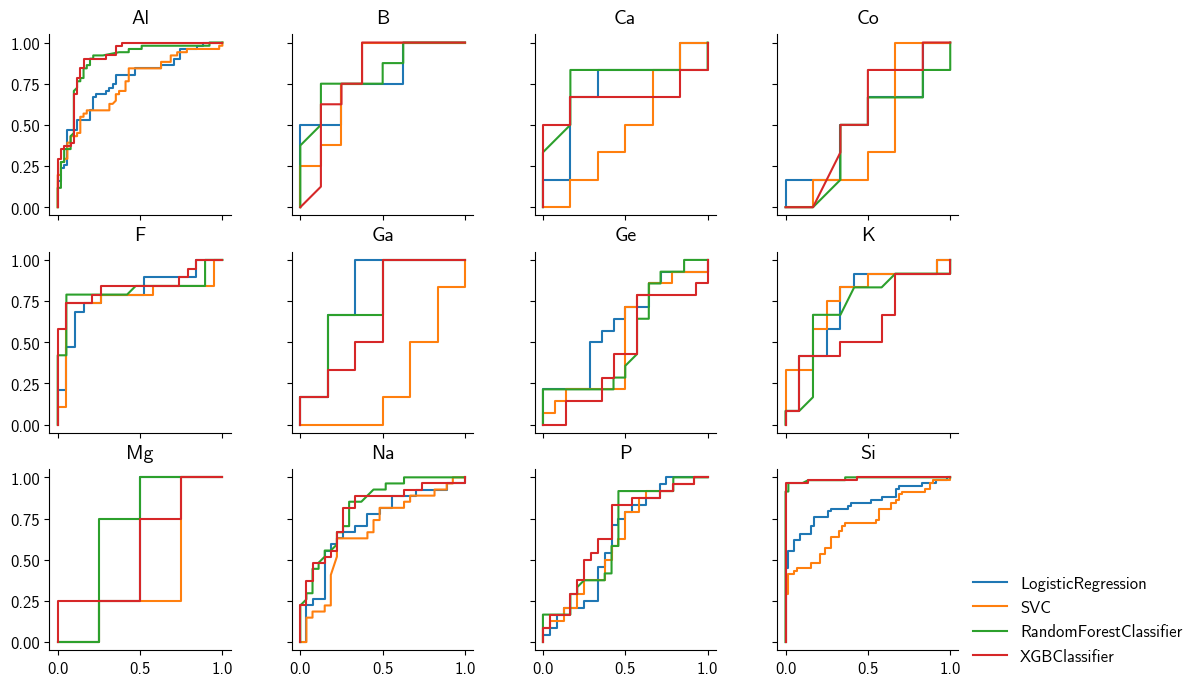

In [13]:
fig, ax_fig = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    for clf, row in _df.set_index("classifier").iterrows():
        ax.plot(
            row["fpr"],
            row["tpr"],
            label=clf,
        )

#     ax.set_xlabel("FP")
#     ax.set_ylabel("TP")
    ax.set_title(label)

    ax.set_aspect("equal")

ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.5))

plt.show()

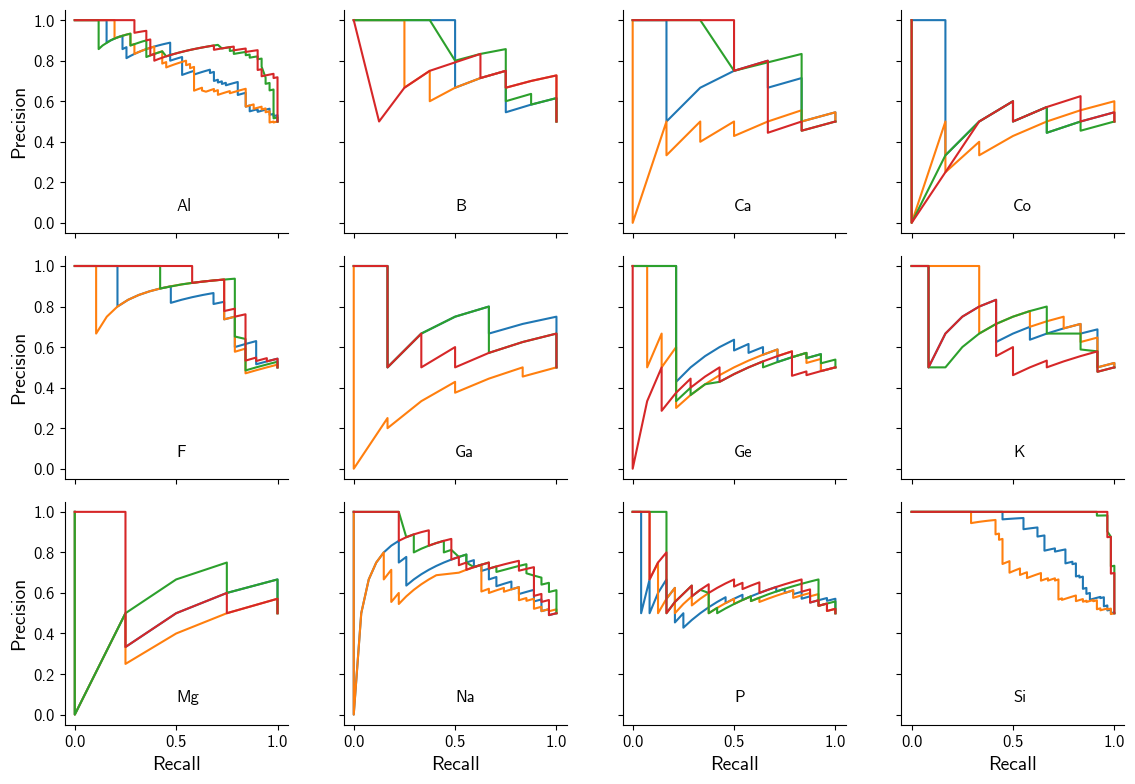

In [18]:
fig, ax_fig = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    for clf, row in _df.set_index("classifier").iterrows():
        ax.plot(
            row["rc"],
            row["pr"],
            label=clf,
        )

    ax.annotate(label, (0.5, 0.1), xycoords='axes fraction')
    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("Recall")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("Precision")
    
# ax.legend(frameon=False, bbox_to_anchor=(1.20, 0.5))

fig.tight_layout()

plt.show()

In [178]:
row = results_df.loc[
    (results_df["label"] == "B")
    & (results_df["classifier"] == "XGBClassifier")
].iloc[0]

In [179]:
confusion_matrix(row["y_test"], row["y_pred"])

array([[7, 1],
       [1, 7]])

In [180]:
row["y_test"], row["y_pred"]

(array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]))